In [1]:
import pandas as pd
from os.path import join
from sklearn.pipeline import make_pipeline
from sklearn.datasets import make_regression, make_low_rank_matrix
from sklearn.gaussian_process.kernels import RBF, WhiteKernel
from gprEmbedding import SubspaceKernel, EmbeddingRBF
from sklearn.gaussian_process import GaussianProcessRegressor

import pandas as pd
import numpy as np

In [2]:
path = 'example_data'
trainX = pd.read_csv(join(path, 'trainX.csv'), index_col=0)
trainY = pd.read_csv(join(path, 'trainY.csv'), index_col=0)
    
testX = pd.read_csv(join(path, 'testX.csv'), index_col=0)
testY = pd.read_csv(join(path, 'testY.csv'), index_col=0)

In [3]:
trainX.head()

,VCD,Glc,Gln,Amm,Lac,product,reactor_temperature,pH,reactor_volume,stirring_rate,inital_volume,total_run_time,product_is_clever_lemon,product_is_relaxed_soup,product_is_novel_brick,product_is_savage_yogurt,product_is_forgiving_crumble,product_is_NNcurious_pretzel
0,0.622433,-1.020776,-0.678715,-1.002060,0.202534,-1.113513,0.767683,1.438053,-0.032582,0.145468,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,-0.334847,0.520189,1.288567,-0.421035,-0.997017,-1.104210,0.540430,0.253870,0.778337,0.559997,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0.729871,2.352416,-0.032219,0.002495,0.406748,0.684492,-0.745764,0.197531,-0.032582,0.687598,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,0.997949,-0.296204,-0.634980,-0.383267,-0.115214,-0.196340,-0.961809,1.392019,-0.032582,-1.000255,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0.480179,-1.152567,1.094763,0.410122,-0.177076,-0.009610,0.098591,1.010149,0.778337,-0.170512,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0


# Example Data
The example data set is concerned with cell processes in biology. For different cell lines (or products) we predict the growth rate of the cells. 

The target `y` is the current rate of cell growth.  
The features `X` contain real valued information like Temperature, pH or current concentrations of nutrients in the brooth. Additionally,
the identity of the product is represented with a one-hot vector in the last 6 columns. 

The data has already been scalled within each product. 

# The Method
We implemented a custom kernel `EmbeddingRBF` that will essentially replace the one-hot vectors in the raw data with a learned embedding vector. It implements the kernel function

$$k(x, y) =  exp(- ||Wx- Wy||^2 ) $$

where W is a learned matrix. `x` and `y` are one-hot vectors. This kernel is applied to the one-hot vector that encodes the product identity and multiplied with an RBF kernel on the remaining features. This is equivalent to replacing the one-hot vectors with the learned embeddings (correct columns in W) and then feeding them together with the normal features into a normal RBF kernel.

In [4]:
n_features = 12 # the number of normal features
n_products = 6 # the number of products 
embedding_dimension = 2 # can be choosen freely

prod_col_names = trainX.columns.values[-n_products:].tolist() # the names of the columns encoding the product identity
prod_col_names 

['product_is_clever_lemon',
 'product_is_relaxed_soup',
 'product_is_novel_brick',
 'product_is_savage_yogurt',
 'product_is_forgiving_crumble',
 'product_is_NNcurious_pretzel']

In [5]:
# Apply RBF kernel to the normal features
raw_normal_feature_kernel = RBF(length_scale = [1.0]*n_features)

# The SubspaceKernel ensures that the RBF kernel is only applied to the first 10 features
normal_feature_kernel = SubspaceKernel(raw_normal_feature_kernel, ids_to_apply=np.arange(0, n_features))



# Apply Embedding kernel to the last 6 features, that contain a one-hot representation of the product
raw_embedding_kernel = EmbeddingRBF.make4EntityEmbed(n_entities=n_products, embedding_dimension=embedding_dimension)

# Use SubspaceKernel to indicate that the one-hot feature representation is contained in the last 6 columns
embedding_kernel = SubspaceKernel(raw_embedding_kernel, ids_to_apply=np.arange(n_features, n_features+n_products))

# Combine the kernel and allow for Noise
full_kernel = 1**2*normal_feature_kernel*embedding_kernel + WhiteKernel()

In [6]:
embedding_gp = GaussianProcessRegressor(kernel=full_kernel, n_restarts_optimizer=3)

embedding_gp.fit(trainX, trainY)

GaussianProcessRegressor(kernel=1**2 * SubspaceKernel(RBF(length_scale=[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]) on [ 0  1  2  3  4  5  6  7  8  9 10 11]) * SubspaceKernel(EmbeddingRBF(1.31, 1.32, 1.24, 1.52, 1.51, 1.6, 1.1, 1.11, 0.75, 0.276, 0.907, 0.571) on [12 13 14 15 16 17]) + WhiteKernel(noise_level=1),
                         n_restarts_optimizer=3)

In [7]:
y_hat_embed = embedding_gp.predict(testX)

In [8]:
embedding_gp.log_marginal_likelihood()

299.5136338098987

In [9]:
error = np.mean((y_hat_embed - testY.values)**2)
print('Test error: {}'.format(error))

Test error: 0.09945956769960576


# Evaluating the Embeddings

In [10]:
# We first need to get the trained kernel (i.e. with optimised hyperparameter). Dont forget the underscore in the end !!!
trained_kernel = embedding_gp.kernel_

embedding_kernel = trained_kernel.k1.k2.base_kernel # the trained_kernel is a composite kernel. We go down the tree until we have the embedding kernel
W = embedding_kernel.W # contains the entity embeddings as column vectors

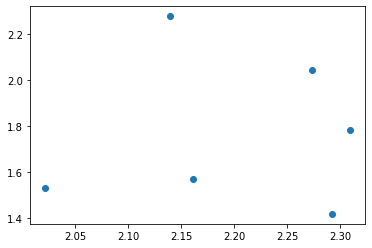

In [11]:
from matplotlib import pyplot as plt
plt.scatter(W[0, :], W[1, :])